# IForest
## 思路
https://www.jianshu.com/p/5af3c66e0410?utm_campaign=maleskine

首先，我们先了解下该算法的动机。目前学术界对异常（anomaly detection）的定义有很多种，iForest 适用与连续数据（Continuous numerical data）的异常检测，将异常定义为“容易被孤立的离群点 (more likely to be separated)”——可以理解为分布稀疏且离密度高的群体较远的点。用统计学来解释，在数据空间里面，分布稀疏的区域表示数据发生在此区域的概率很低，因而可以认为落在这些区域里的数据是异常的。

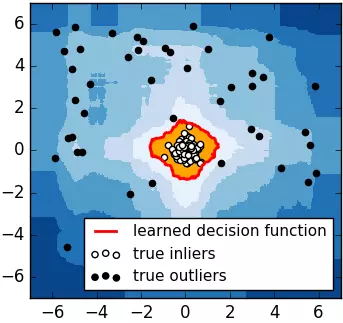

黑色的点为异常点，白色点为正常的点（在一个簇中）。iForest检测到的异常边界为红色，它可以正确地检测到所有黑点异常点。

### iForest属于Non-parametric和unsupervised的方法，
即不用定义数学模型也不需要有标记的训练。

对于如何查找哪些点是否容易被孤立（isolated），iForest使用了一套非常高效的策略。

假设我们用一个随机超平面来切割（split）数据空间（data space）, 切一次可以生成两个子空间（想象拿刀切蛋糕一分为二）。之后我们再继续用一个随机超平面来切割每个子空间，循环下去，直到每子空间里面只有一个数据点为止。直观上来讲，我们可以发现那些密度很高的簇是可以被切很多次才会停止切割，但是那些密度很低的点很容易很早的就停到一个子空间了。

上图里面黑色的点就很容易被切几次就停到一个子空间，而白色点聚集的地方可以切很多次才停止。

### 怎么来切这个数据空间是iForest的设计核心思想，

本文仅介绍最基本的方法。由于切割是随机的，所以需要用ensemble的方法来得到一个收敛值（蒙特卡洛方法），即反复从头开始切，然后平均每次切的结果。

iForest 由t个iTree（Isolation Tree）孤立树 组成，每个iTree是一个二叉树结构，其实现步骤如下：
1. 从训练数据中随机选择Ψ个点样本点作为subsample，放入树的根节点。
2. 随机指定一个维度（attribute），在当前节点数据中随机产生一个切割点p——切割点产生于当前节点数据中指定维度的最大值和最小值之间。
3. 以此切割点生成了一个超平面，然后将当前节点数据空间划分为2个子空间：把指定维度里小于p的数据放在当前节点的左孩子，把大于等于p的数据放在当前节点的右孩子。
4. 在孩子节点中递归步骤2和3，不断构造新的孩子节点，直到 孩子节点中只有一个数据（无法再继续切割） 或 孩子节点已到达限定高度 。

获得t个iTree之后，iForest 训练就结束，然后我们可以用生成的iForest来评估测试数据了。对于一个训练数据x，我们令其遍历每一棵iTree，然后计算x最终落在每个树第几层（x在树的高度）。然后我们可以得出x在每棵树的高度平均值，即 the average path length over t iTrees。值得注意的是，如果x落在一个节点中含多个训练数据，可以使用一个公式来修正x的高度计算，详细公式推导见原论文。

获得每个测试数据的average path length后，我们可以设置一个阈值（边界值），average path length 低于此阈值的测试数据即为异常。也就是说 “iForest identifies anomalies as instances having the shortest average path lengths in a dataset ”(异常在这些树中只有很短的平均高度). *值得注意的是，论文中对树的高度做了归一化，并得出一个0到1的数值，即越短的高度越接近1（异常的可能性越高）。4个测试样本遍历一棵iTree的例子如下：

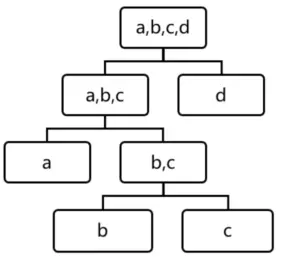

可以看到d最有可能是异常，因为其最早就被孤立（isolated）了。

# sklearn IsolationForest
https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

实现code：https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/ensemble/iforest.py#L29

`sklearn.ensemble.IsolationForest(n_estimators=100, max_samples=’auto’, contamination=’legacy’, max_features=1.0, bootstrap=False, n_jobs=None, behaviour=’old’, random_state=None, verbose=0, warm_start=False)`

* n_estimators : int, optional (default=100)
The number of base estimators in the ensemble.

* max_samples : int or float, optional (default=”auto”)
The number of samples to draw from X to train each base estimator.

    * If int, then draw max_samples samples.
    * If float, then draw max_samples * X.shape[0] samples.
    * If “auto”, then max_samples=min(256, n_samples).
    * If max_samples is larger than the number of samples provided, all samples will be used for all trees (no sampling).

* contamination : float in (0., 0.5), optional (default=0.1)
The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function. If ‘auto’, the decision function threshold is determined as in the original paper.

* max_features : int or float, optional (default=1.0)
The number of features to draw from X to train each base estimator.

    * If int, then draw max_features features.
    * If float, then draw max_features * X.shape[1] features.

* n_jobs : int or None, optional (default=None)
The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

## Generate train data

In [2]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

## fit the model

In [3]:
clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=rng, contamination='auto')
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

In [4]:
y_pred_test

array([ 1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1, -1, -1,  1])

In [5]:
y_pred_outliers

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

## plot the line, the samples, and the nearest vectors to the plane

In [9]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))

In [14]:
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Z[:5]

array([[-0.13413756, -0.13413756, -0.13413756, -0.13413756, -0.13413756,
        -0.13413756, -0.13413756, -0.13413756, -0.13413756, -0.13413756,
        -0.13413756, -0.12853627, -0.12025778, -0.08773074, -0.04964979,
        -0.03409079, -0.0570899 , -0.09870029, -0.1135743 , -0.11205086,
        -0.11477633, -0.11383374, -0.11271196, -0.11159222, -0.11167049,
        -0.11167049, -0.1091414 , -0.11515325, -0.11566321, -0.11217757,
        -0.11167049, -0.10954162, -0.09296122, -0.08250661, -0.07796984,
        -0.08161331, -0.10183266, -0.11929298, -0.11980638, -0.11980638,
        -0.11980638, -0.11980638, -0.11980638, -0.11980638, -0.11980638,
        -0.11980638, -0.11980638, -0.11980638, -0.11980638, -0.11980638],
       [-0.13413756, -0.13413756, -0.13413756, -0.13413756, -0.13413756,
        -0.13413756, -0.13413756, -0.13413756, -0.13413756, -0.13413756,
        -0.13413756, -0.12853627, -0.12025778, -0.08773074, -0.04964979,
        -0.03409079, -0.0570899 , -0.09870029, -0.

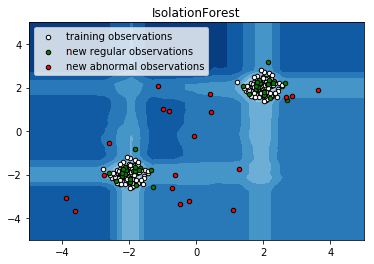

In [7]:
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()